<a href="https://colab.research.google.com/github/SuperTonik/Hobby/blob/main/cnn_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Feed-forward neural network (FNN) is a type of artificial neural network. FNN consists of input layer which is followed by hidden layers and then an output layer. Data flows from the input layer through the hidden layers making it a uni-directional network.

The hidden layer of the FNN consists of nodes. These individual notes have activation functions which govern the node's output given some input and a weight. An example of an activation function is the popular rectified linear unit (ReLu).

$f(x) = max(0, x) = \frac{x + |x|}{2} = \begin{cases} x, & \text{if}\; x > 0, \\ 0 & \text{otherwise.}\end{cases}$

Earliest and most simple FNN was actually used by Legendre and Gauss in early 19th century to predict planetary movement.

The problem with FNN is that even small inputs require many weights for a each node. The number of weight per node can be reduced with convolution.

## Convolution
Convolution itself is a pretty hefty topic. In mathematical terms convolution of functions $f$ and $g$ is
$ (f * g)(t) := \int_{-\infty}^{\infty} f(t-\tau)g(\tau)d\tau.$

As a very simple example, we consider two sets $a = \{2, 4, 6\}$ and $b = \{1,2,3\}$. The convolution of this is calculated as

$ (a*b) = \{2*1, 2*2+4*1, 3*2+2*4+1*6, 3*4+2*6, 3*6\} = \{2, 8, 20, 24, 18\}.$

This can be verified using NumPy.

In [58]:
import numpy as np

a = np.array([2, 4, 6])
b = np.array([1, 2, 3])

print(np.convolve(a, b))

[ 2  8 20 24 18]


Convolution is used in image processing. For example, Gaussian blur calculates the pixel values using convolution from surrounding pixels. The surrounding pixels refers the kernel used in the method. In Gaussian blur, the kernel is constructed by sampling values from Gaussian distribution, i. e. the center of the kernel has largest value and then the values drop following the distribution. Here is an example of Gaussian kernel which can be generated quite easily:

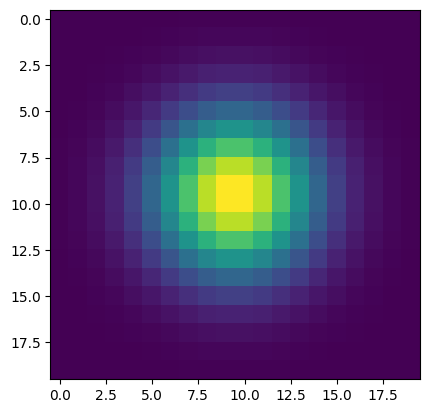

In [59]:
import matplotlib.pyplot as plt

def gaussian_kernel(l, sig):
    """
      Generates a 2D Gaussian kernel with side length of 'l' and sigma of 'sig'.
    """
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

kernel = gaussian_kernel(20, 3)

plt.imshow(kernel)
plt.show()

# Loading up the images

For this case study, I'm going to use MRI scans of brain tumors from Kaggle.

In [60]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rm1000/brain-tumor-mri-scans")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/rm1000/brain-tumor-mri-scans/versions/1


In [61]:
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.optim import lr_scheduler
from torchvision import datasets
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image

# Prefer to use CUDA. In Colab, set T4/GPU from the options.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


The PyTorch models are pretrained. For this reason, the data must be preprocessed correctly, otherwise the accuracy will be bad or even faulty. The preprocessing is done for each image by first loading the transform attribute from the selected weights and applying it to the image. The same preprocessing can also be applied when predicting an actual image.

In [88]:
weights = ResNet50_Weights.DEFAULT
preprocess = weights.transforms()

class CustomImageDataset(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super(CustomImageDataset, self).__init__(root, transform=None)

    def __getitem__(self, index):
        image, label = super(CustomImageDataset, self).__getitem__(index)
        image = preprocess(image)
        return image, label

dataset = CustomImageDataset(path)

train_size = int(0.7 * len(dataset))    # Training dataset size is 70 %
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Let's plot some examples of the dataset for each different case of image.

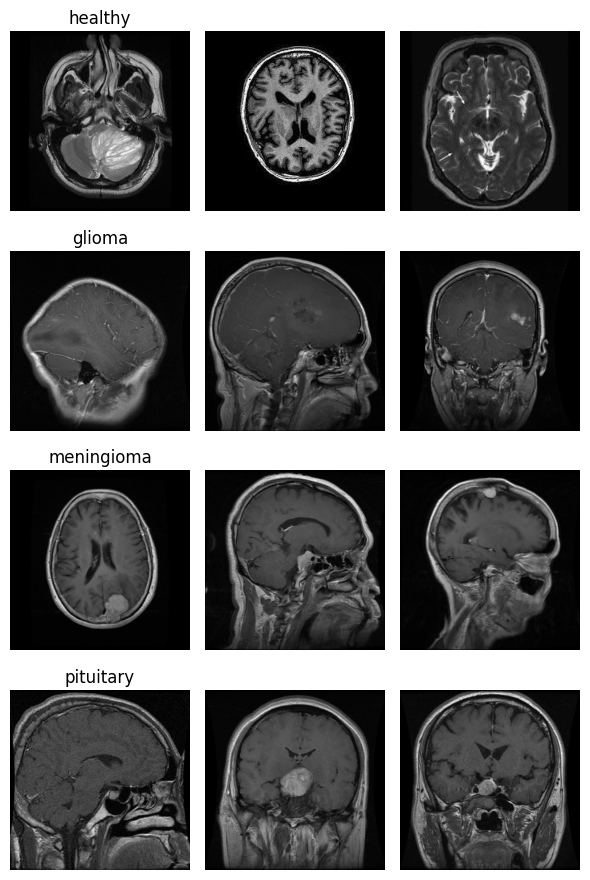

In [63]:
import random

classes = ['healthy', 'glioma', 'meningioma', 'pituitary']

fig, axs = plt.subplots(len(classes), 3, figsize=(6, 9))
for i, class_name in enumerate(classes):
    dir = os.path.join(path, class_name)
    images = random.sample(os.listdir(dir), 3)
    for j, image_name in enumerate(images):
        img = Image.open(os.path.join(dir, image_name))
        axs[i, j].imshow(img)
        axs[i, j].axis('off')
        if j == 0:
            axs[i, j].set_title(class_name)
plt.tight_layout()
plt.show()

# Training the model
[ResNet50](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html) is a type of CNN that is widely used in image predictions. As previously mentioned, the ResNet50 implementation in PyTorch comes with pretrained weights which I'm going to use in this demo.

Criterion defines when the algorithm for the optimizer should stop. [Cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) is suited for this case because we are training a classification problem with $C$ classes.

... WIP

In [64]:
model = resnet50(weights=weights)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5)

In [65]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25):
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

    val_loss, val_acc = evaluate_model(model, val_loader, criterion)
    scheduler.step(val_loss)

    print("Train Loss: {}, Val Loss: {}, Val Acc: {}".format((running_loss/len(train_loader)), val_loss, val_acc))
    history['train_loss'].append(running_loss/len(train_loader))
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    if val_acc > best_acc:
      best_acc = val_acc
      best_model_wts = copy.deepcopy(model.state_dict())

  model.load_state_dict(best_model_wts)
  return model, history

def evaluate_model(model, data_loader, criterion):
  model.eval()
  running_loss = 0.0
  running_corrects = 0
  total = 0
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs, 1)
      running_loss += loss.item()
      running_corrects += (preds == labels).sum().item()
      total += labels.size(0)

  return running_loss / len(data_loader), 100 * running_corrects / total


In [74]:
num_epochs = 25
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)

Epoch 1/25
Train Loss: 0.3001773771950854, Val Loss: 0.2623926838013259, Val Acc: 91.16809116809117
Epoch 2/25
Train Loss: 0.13796720352604405, Val Loss: 0.36097070066766307, Val Acc: 87.6068376068376
Epoch 3/25
Train Loss: 0.09680947879716367, Val Loss: 0.2744410236958753, Val Acc: 91.73789173789174
Epoch 4/25
Train Loss: 0.08949446958465526, Val Loss: 0.1665096418424086, Val Acc: 94.87179487179488
Epoch 5/25
Train Loss: 0.06316306626548168, Val Loss: 0.11167475657368248, Val Acc: 95.72649572649573
Epoch 6/25
Train Loss: 0.02764874390895666, Val Loss: 0.044500006198756055, Val Acc: 98.57549857549857
Epoch 7/25
Train Loss: 0.021379858967957733, Val Loss: 0.4123206684704531, Val Acc: 88.6039886039886
Epoch 8/25
Train Loss: 0.052992366337483485, Val Loss: 3.095018197189678, Val Acc: 60.826210826210826
Epoch 9/25
Train Loss: 0.07336316042422474, Val Loss: 0.18185845732858236, Val Acc: 95.44159544159544
Epoch 10/25
Train Loss: 0.03989922171821455, Val Loss: 0.0641797443068671, Val Acc: 98.

# Results

In [75]:
test_loss, test_acc = evaluate_model(model, test_loader, criterion)
print("Test Loss: {:.4}, Test Acc: {:.4}%".format(test_loss, test_acc))

Test Loss: 0.05024, Test Acc: 98.65%


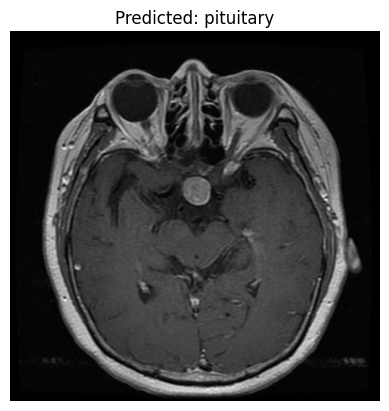

In [85]:
def predict_and_show(model, image_path, classes):
  image = Image.open(image_path)
  image_tensor = preprocess(image).unsqueeze(0).to(device)  # process the image to suit the model

  model.eval()
  with torch.no_grad():
    output = model(image_tensor)
    _, predicted_idx = torch.max(output, 1)
    predicted_class = classes[predicted_idx.item()]

  plt.imshow(image)
  plt.title(f"Predicted: {predicted_class}")
  plt.axis('off')
  plt.show()

predict_and_show(model, os.path.join(path, 'pituitary/0005.jpg'), classes)

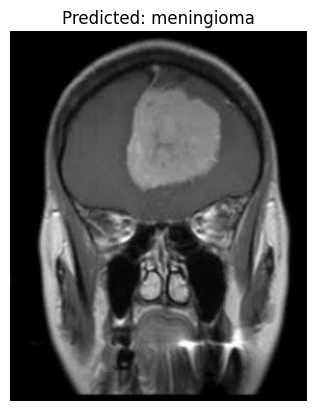

In [87]:
predict_and_show(model, os.path.join(path, 'meningioma/0010.jpg'), classes)